# Are America's Nuclear Plants Doomed?  -- IPython Process Notebook

Final Project for CS109 || Sam Huntington, Danny Chua, and Max DeCurtins

## Table of Contents

**This workbook:**
1. Project Motivation and Overview
2. Data Collection and Processing<br>
2.1 Context<br>
2.2 PJM Prices<br>
2.3 PJM Demand<br>
2.4 PJM & MISO Wind<br>
2.5 Natural Gas Prices<br>
2.6 MISO Demand<br>
2.7 Coal Prices<br>
3. EDA<br>
3.1 Longitudinal plot of prices<br>
3.2 Longitudinal plot of features<br>
3.3 Histgrams of prices and features<br>
3.4 Scatter plots of select features against prices<br>
4. Testing Modeling Techniques<br>
4.1 Multiple Linear Regression<br>
4.2 Ridge Regression<br>
4.3 Random Forest Regression<br>
5. Final Analysis: Forward Forecasting<br>
5.1 Double wind penetration<br>
5.2 Double natural gas price (carbon tax)<br>
5.3 Deep Decarbonization Scenario<br>
6. Revisiting Initial Questions
7. Limitations and Future Improvements
<br><br>

**External Workbooks**<br><br>
Webscraping:
- Natural Gas and Coal commodity prices:        *~/1. Data Wrangling - MISO/Commodity Prices*
- Wind generation in MISO:                      *~/1. Data Wrangling - MISO/Wind Generation*
- Electricity Demand in MISO:                   *~/1. Data Wrangling - MISO/Demand Scraper*
- PJM nodal electricity prices:                 *~/4. PJM Data/pjm_dayahead*

Initial EDA:
- Coal, gas, and wind generation over time:      *~/2. EDA/Features over time*
- Scatter plots of elec prices against coal/NG:  *~/2. EDA/Relationship between variables*





## 1. Project Motivation and Overview

Recently, owners of nuclear power plants in the midwest have seen their [profitability decline](http://articles.chicagotribune.com/2014-03-09/business/ct-exelon-closing-nuclear-plants-0308-biz-20140309_1_quad-cities-plant-byron-plant-exelon). In particular, Exelon corporation, the owner of several nuclear plants in northern Illinois, has lobbied for policy changes to secure their revenues and ensure their ongoing financial viability. These arguments are cast against the backdrop of an electricity sector being pushed to integrate more low-carbon sources of electricity. As nuclear currently constitutes the [largest source](https://www.eia.gov/tools/faqs/faq.cfm?id=427&t=3) of low-carbon power in the US, shuttering of these plants would make it more difficult to comply with the EPA's [Clean Power Plan](http://www2.epa.gov/cleanpowerplan/clean-power-plan-existing-power-plants) regulations, and, more generally, would make it more difficult to achieve the long-term emissions reductions neccessary to avoid the worst effects of climate change. Policymakers are now faced with the dilemna of whether or not and by how much to support these plants. 

This raises several interesting questions. Like all power plants, nuclear generator revenues are a function of electricity prices - but what factors drive electricity prices? What recent trends have resulted in depressed electricity prices? How accurately could we forecast future prices? If we were able to do so effectively it could inform policymakers about the conditions under which subsidies or other support instruments might be justified, and perhaps give them a rough estimate (upper and lower bound) of the level of support needed. 

This policy debate, and the associated questions, served as the motivation for this project. The goal at the outset was to develop a predictive model of the electricity prices.

In [100]:
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import requests
import json
import datetime

from IPython.display import display, HTML

## 2. Data Collection and Processing

### 2.1 Context
Since nuclear plant revenues are a function of the price of electricity, and the price of electricity varies by location, it is important to understand where precisely the plants are located so that we can be confident we are working with the right data. The image below shows the locations of Exelon's six nuclear plants in northern Illinois. 

<img src="nukes.png">
<small><small>Source: Nuclear Plant location: http://www.eia.gov/state/maps.cfm, Power System Map: http://www.miso-pjm.com/

While the plants are all located in the [PJM](http://www.pjm.com/) system (a single regional market for wholesale electricity), the area where the plants are located is surrounded by a different system: [MISO](https://www.misoenergy.org/Pages/Home.aspx). This is important because the two systems are highly interconnected, meaning power flows easily between the two systems and factors affecting prices in one system also affect prices in the other. This effectively doubled our data collection task.

#### What factors drive electricity prices?
As in any competitive market, wholesale electricity prices are a function of [supply and demand](http://www.nordpoolspot.com/How-does-it-work/). Prices are set by auction where generators submit bids roughly equivalent to their operating cost (for nuclear plants this may be the cost of maintenance, while for gas and coal plants this is the cost of fuel. Wind is free and is therefore always dispatched). Gas and coal plants are often the marginal generators (the last to clear the auction and set the price) and therefore their fuel costs are highly correlated with [electricity prices](http://www.eia.gov/EnergyExplained/index.cfm?page=electricity_factors_affecting_prices). Wind generation, which is growing rapidly, reduces electricity prices by [pushing out the supply curve](https://en.wikipedia.org/wiki/Merit_order).  

For these reasons we chose the following features to use in our predictive model:
- electricity demand
- natural gas prices
- coal prices
- wind generation

The remainder of this section details how we cleaned and processed each of our main data sources (actual scraping is done in other workbooks - see TOC as top).

### 2.2 PJM Prices
The nuclear plants identified above are located at specific "nodes" - points of connection with the transmission network where prices are established. We used the node IDs ("pnodeID" in the table below) to scrape their corresponding prices from the PJM website. Some plants connect to multiple nodes (one for each reactor), in which case we average them. The prices are at an hourly granularity for the years 2008-2015 (68k rows).

The webscraper for this dataset is located [here](https://github.com/dannychua/Electricity-Price-Predictor/blob/master/4.%20PJM%20Data/pjm_dayahead.ipynb).

In [14]:
pjmdf = pd.read_csv('data/pjm_dayahead_rawdf.csv')
pjmdf.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
pjmdf.head(2)

,pnodeId,price_01,price_02,price_03,price_04,price_05,price_06,price_07,price_08,price_09,price_10,price_11,price_12,price_13,price_14,price_15,price_16,price_17,price_18,price_19,price_20,price_21,price_22,price_23,price_24,publishDate
0,32417601,24.15,23.1,21.91,21.08,20.84,21.32,22.55,23.86,24.42,25.15,25.39,26.29,25.84,25.71,25.55,25.44,26.30,42.40,60.56,54.69,45.31,34.56,29.84,25.54,2008-01-01
1,32417601,26.43,25.7,25.58,25.27,25.53,30.45,55.32,66.16,70.70,66.22,63.54,53.78,46.65,44.25,39.70,37.93,40.74,81.39,96.11,82.96,74.83,62.65,50.67,37.44,2008-01-02


The raw data is an inconvenient structure, so we reformat:

In [15]:
idx = pd.date_range('1/1/2008', '11/01/2015 23:00:00', freq = 'H')
df = pd.DataFrame(index = idx)

for node in pjmdf['pnodeId'].unique():
    nodedf = pjmdf[pjmdf['pnodeId']==node]
    nodedf = nodedf.drop('pnodeId',1)
    nodedf = nodedf.drop('publishDate',1)
    nodedf = nodedf.fillna(0)
    nodedf = nodedf.stack()
    col_name = 'lmp_' + str(node)[-3:]
    nodedf.index = idx
    df[col_name] = nodedf

fulldf = pd.DataFrame(index = idx)

fulldf['Clinton_LMP_($/MWh)'] = df['lmp_673']
fulldf['LaSalle_LMP_($/MWh)'] = df[["lmp_525", "lmp_527"]].mean(axis=1)
fulldf['Dresden_LMP_($/MWh)'] = df[["lmp_545", "lmp_547"]].mean(axis=1)
fulldf['Braidwood_LMP_($/MWh)'] = df[["lmp_599", "lmp_601"]].mean(axis=1)
fulldf['QuadCities_LMP_($/MWh)'] = df[["lmp_629", "lmp_631"]].mean(axis=1)
fulldf['Byron_LMP_($/MWh)'] = df[["lmp_633", "lmp_635"]].mean(axis=1)
fulldf.head(2) 

,Clinton_LMP_($/MWh),LaSalle_LMP_($/MWh),Dresden_LMP_($/MWh),Braidwood_LMP_($/MWh),QuadCities_LMP_($/MWh),Byron_LMP_($/MWh)
2008-01-01 00:00:00,42.90,24.055,24.39,24.145,23.45,23.580
2008-01-01 01:00:00,39.33,23.015,23.32,23.100,22.40,22.455


Now we have the skeleton for the dataframe that will eventually hold all of our data: columns corresponding to each feature, and rows corresponding to hourly data points stretching from 2008-2015. 

Each of the columns in this initial frame corresponds to the price (LMP = locational marginal price) at a specific reactor.

### 2.3 PJM Electricity Demand Data

Webscraper located [here](http://localhost:8888/notebooks/Electricity-Price-Predictor/1.%20Data%20Wrangling%20-%20MISO/Demand%20Scraper.ipynb)

In [16]:
# Load raw data from web scraper
ldf = pd.read_csv('data/PJM_hourly_load_08_15.csv')
ldf = ldf.drop('DATE',1)
ldf = ldf.drop('COMP',1)
ldf = ldf.drop('Unnamed: 26',1)
ldf = ldf.drop('Unnamed: 27',1)
ldf = ldf.stack()
idx = pd.date_range('1/1/2008', periods = len(ldf), freq = 'H')
ldf.index = idx
#interpolate missing values
ldf = ldf.replace(0,np.NaN)
ldf = pd.DataFrame(ldf)
ldf.apply(pd.Series.interpolate)
#trim it to appropirate length and add into price dataframe
d = '2015-11-01 23:00:00'
ldf = ldf.ix[:d]
fulldf['Demand_PJM_(MWh)'] = ldf
fulldf.head(2)

,Clinton_LMP_($/MWh),LaSalle_LMP_($/MWh),Dresden_LMP_($/MWh),Braidwood_LMP_($/MWh),QuadCities_LMP_($/MWh),Byron_LMP_($/MWh),Demand_PJM_(MWh)
2008-01-01 00:00:00,42.90,24.055,24.39,24.145,23.45,23.580,33534
2008-01-01 01:00:00,39.33,23.015,23.32,23.100,22.40,22.455,32632


### 2.4 PJM & MISO Wind Generation Data

Webscraper located [here](https://github.com/dannychua/Electricity-Price-Predictor/blob/master/1.%20Data%20Wrangling%20-%20MISO/Wind%20Generation.ipynb)

In [17]:
# PJM
pjm_wdf = pd.read_csv('data/PJM_Wind/PJM_hourly_wind_08_15.csv')
pjm_wdf = pjm_wdf.drop('DATE',1)
pjm_wdf = pjm_wdf.drop('COMP',1)
pjm_wdf = pjm_wdf.fillna(0)
pjm_wdf = pjm_wdf.stack()
num_hours = len(pjm_wdf)
idx = pd.date_range('1/1/2008', periods = num_hours, freq = 'H')
pjm_wdf.index = idx

# MISO
wdf = pd.read_csv('data/MISO_wind_hourly.csv')
wdf = wdf.drop('Date',1)
num_hours = len(wdf)
idx = pd.date_range('1/1/2008', periods = num_hours, freq = 'H')
wdf.index = idx

# Trim both data sets to an equal size
d = '2015-11-01 23:00:00'
pjm_wdf = pjm_wdf.ix[:d]
wdf = wdf.ix[:d]

# Merge into a single df
wdf['Wind_PJM'] = pjm_wdf
wdf.columns = ['Wind_MISO_(MWh)', 'Wind_PJM_(MWh)']
# d = '2015-11-01 23:00:00'
# wdf_trim = wdf.ix[:d]
fulldf = pd.merge(fulldf, wdf, left_index=True, right_index=True)
fulldf.head(2)

,Clinton_LMP_($/MWh),LaSalle_LMP_($/MWh),Dresden_LMP_($/MWh),Braidwood_LMP_($/MWh),QuadCities_LMP_($/MWh),Byron_LMP_($/MWh),Demand_PJM_(MWh),Wind_MISO_(MWh),Wind_PJM_(MWh)
2008-01-01 00:00:00,42.90,24.055,24.39,24.145,23.45,23.580,33534,1104.05,697.102
2008-01-01 01:00:00,39.33,23.015,23.32,23.100,22.40,22.455,32632,1210.31,679.046


### 2.5 Natural Gas Data

Webscraper for this data located [here](https://github.com/dannychua/Electricity-Price-Predictor/blob/master/1.%20Data%20Wrangling%20-%20MISO/Commodity%20Prices.ipynb)

In [18]:
# Build empty Df with date index 
idx = pd.date_range('1/1/2008', '11/01/2015', freq = 'D')
ngdf = pd.DataFrame(index=idx)

# read in NG daily data
ng_raw = pd.read_csv('data/NGPrices.csv')
d = '2008-01-01'
ng_raw = ng_raw[ng_raw['date']>=d]
ng_raw['date'] = pd.to_datetime(ng_raw['date'])
ng_raw = ng_raw.set_index('date')

# map raw daily data to empty df with full dates, interpolate missing values
ngdf['NG_HH'] = ng_raw
ngdf = ngdf.interpolate(method='time')
ngdf.values[0] = ngdf.values[1]
ngdf.head()

# add a column for each hour of day
for i in range (23):
    ngdf[i] = ngdf['NG_HH']

# stack columns and replace index with hourly
ngdf = ngdf.stack()
idx = pd.date_range('1/1/2008', periods = len(ngdf), freq = 'H') 
ngdf.index = idx
fulldf['NatGas_Price_($/MMBtu)'] = ngdf
fulldf.head(2)

,Clinton_LMP_($/MWh),LaSalle_LMP_($/MWh),Dresden_LMP_($/MWh),Braidwood_LMP_($/MWh),QuadCities_LMP_($/MWh),Byron_LMP_($/MWh),Demand_PJM_(MWh),Wind_MISO_(MWh),Wind_PJM_(MWh),NatGas_Price_($/MMBtu)
2008-01-01 00:00:00,42.90,24.055,24.39,24.145,23.45,23.580,33534,1104.05,697.102,7.83
2008-01-01 01:00:00,39.33,23.015,23.32,23.100,22.40,22.455,32632,1210.31,679.046,7.83


### 2.6 MISO Electricity Demand Data

Webscraper for this data is located [here](https://github.com/dannychua/Electricity-Price-Predictor/blob/master/1.%20Data%20Wrangling%20-%20MISO/Demand%20Scraper.ipynb)

In [19]:
mdf = pd.read_csv('data/Load_MISO_central_west.csv')
mdf.columns = ['date','Load_MISO_Central']
idx = pd.date_range('7/6/2009', periods = len(mdf), freq = 'H') 
mdf.index = idx
mdf = mdf.drop('date',1)
inds = pd.isnull(mdf).any(1).nonzero()[0]
mdf.iloc[inds[0]] = np.mean([mdf.iloc[inds[0]+1][0],mdf.iloc[inds[0]-1][0]])
fulldf['Load_MISO_(MWh)'] = mdf
fulldf.head(2)

,Clinton_LMP_($/MWh),LaSalle_LMP_($/MWh),Dresden_LMP_($/MWh),Braidwood_LMP_($/MWh),QuadCities_LMP_($/MWh),Byron_LMP_($/MWh),Demand_PJM_(MWh),Wind_MISO_(MWh),Wind_PJM_(MWh),NatGas_Price_($/MMBtu),Load_MISO_(MWh)
2008-01-01 00:00:00,42.90,24.055,24.39,24.145,23.45,23.580,33534,1104.05,697.102,7.83,NaN
2008-01-01 01:00:00,39.33,23.015,23.32,23.100,22.40,22.455,32632,1210.31,679.046,7.83,NaN


Note that MISO demand data doesn't go back as far as the others (only to 2008-07-06, where the others go back to 2008-01-01). We trim this later.

### 2.7 Coal Prices

Webscraper for this data is located [here](https://github.com/dannychua/Electricity-Price-Predictor/blob/master/1.%20Data%20Wrangling%20-%20MISO/Commodity%20Prices.ipynb)

In [20]:
# Commodity Prices
dfCommodity = pd.read_csv('data/commodityPrices.csv')
dfCommodity['date'] = pd.to_datetime(dfCommodity['date'])
dfCommodity = dfCommodity.set_index('date').sort_index()
dfCommodity = dfCommodity.drop('NgPrice',1)
dfCommodity.head(2)

,Central Appalachia,Northern Appalachia,Illinois Basin,Powder River Basin,Uinta Basin
date,,,,,
2008-05-06,116.500000,105,61.250000,14.250000,43.5
2008-05-07,116.642857,105,61.535714,14.142857,43.5


In [21]:
headers = list(dfCommodity)
idx1 = pd.date_range('5/6/2008', '11/01/2015', freq = 'D')

for col in headers:
    tempdf = pd.DataFrame(index=idx1)
    tempdf[col] = dfCommodity[col]
    tempdf = tempdf.interpolate(method='time')   
    for i in range(23):
        tempdf[i] = tempdf[col]
    tempdf = tempdf.stack()
    idx2 = pd.date_range('5/6/2008', periods=len(tempdf), freq = 'H') 
    tempdf.index = idx2
    fulldf['Coal_'+col] = tempdf
    tempdf = None

fulldf.tail(2)


,Clinton_LMP_($/MWh),LaSalle_LMP_($/MWh),Dresden_LMP_($/MWh),Braidwood_LMP_($/MWh),QuadCities_LMP_($/MWh),Byron_LMP_($/MWh),Demand_PJM_(MWh),Wind_MISO_(MWh),Wind_PJM_(MWh),NatGas_Price_($/MMBtu),Load_MISO_(MWh),Coal_Central Appalachia,Coal_Northern Appalachia,Coal_Illinois Basin,Coal_Powder River Basin,Coal_Uinta Basin
2015-11-01 22:00:00,20.18,20.960,21.325,21.01,9.41,-0.93,25875.341,5709.02,3472,1.98,32938.60,49,52,32.75,11.55,40.55
2015-11-01 23:00:00,20.15,19.535,19.860,19.58,8.31,-2.08,27638.429,5065.43,3200,1.98,31462.12,49,52,32.75,11.55,40.55


## 3. Exploratory Data Analysis

#### 3.1 Longitudinal plot of prices at each reactor location

/Users/x/anaconda/envs/data/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  either being pressed.


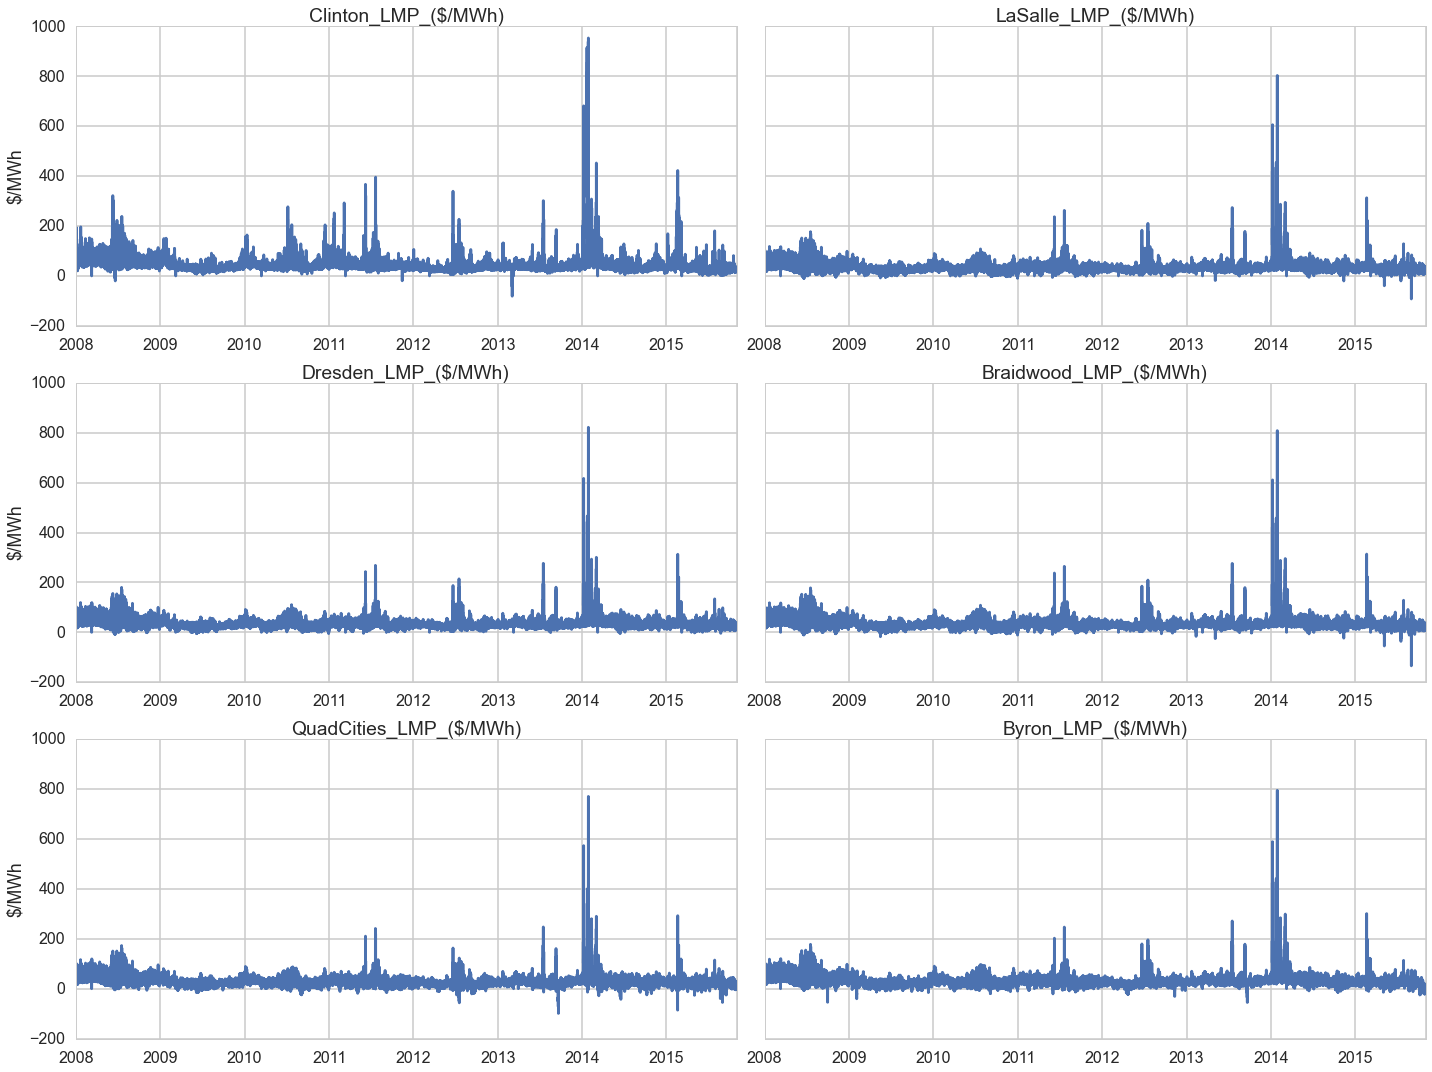

In [11]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15),tight_layout=True,sharey=True)
lmpdf = fulldf.iloc[:,0:6]
headers = list(lmpdf)
ax = axes.ravel()

for i in range(6):
    k = lmpdf.iloc[:,i]
    k.plot(ax=ax[i], title=headers[i])
    ax[i].set_ylabel("$/MWh")

Above we see the hourly prices at each "node" plotted for the years 2008-2015. Clearly they follow the same general pattern, though there are slight differences between them - for example, Clinton has several spikes in 2011 that other locations do not show. It is difficult to see from these graphs if average prices have declined much over the past 5 years (as Exelon claims), though we do see generally higher prices at the beginning of our data in 2008.

#### 3.2 Longitudinal plots features

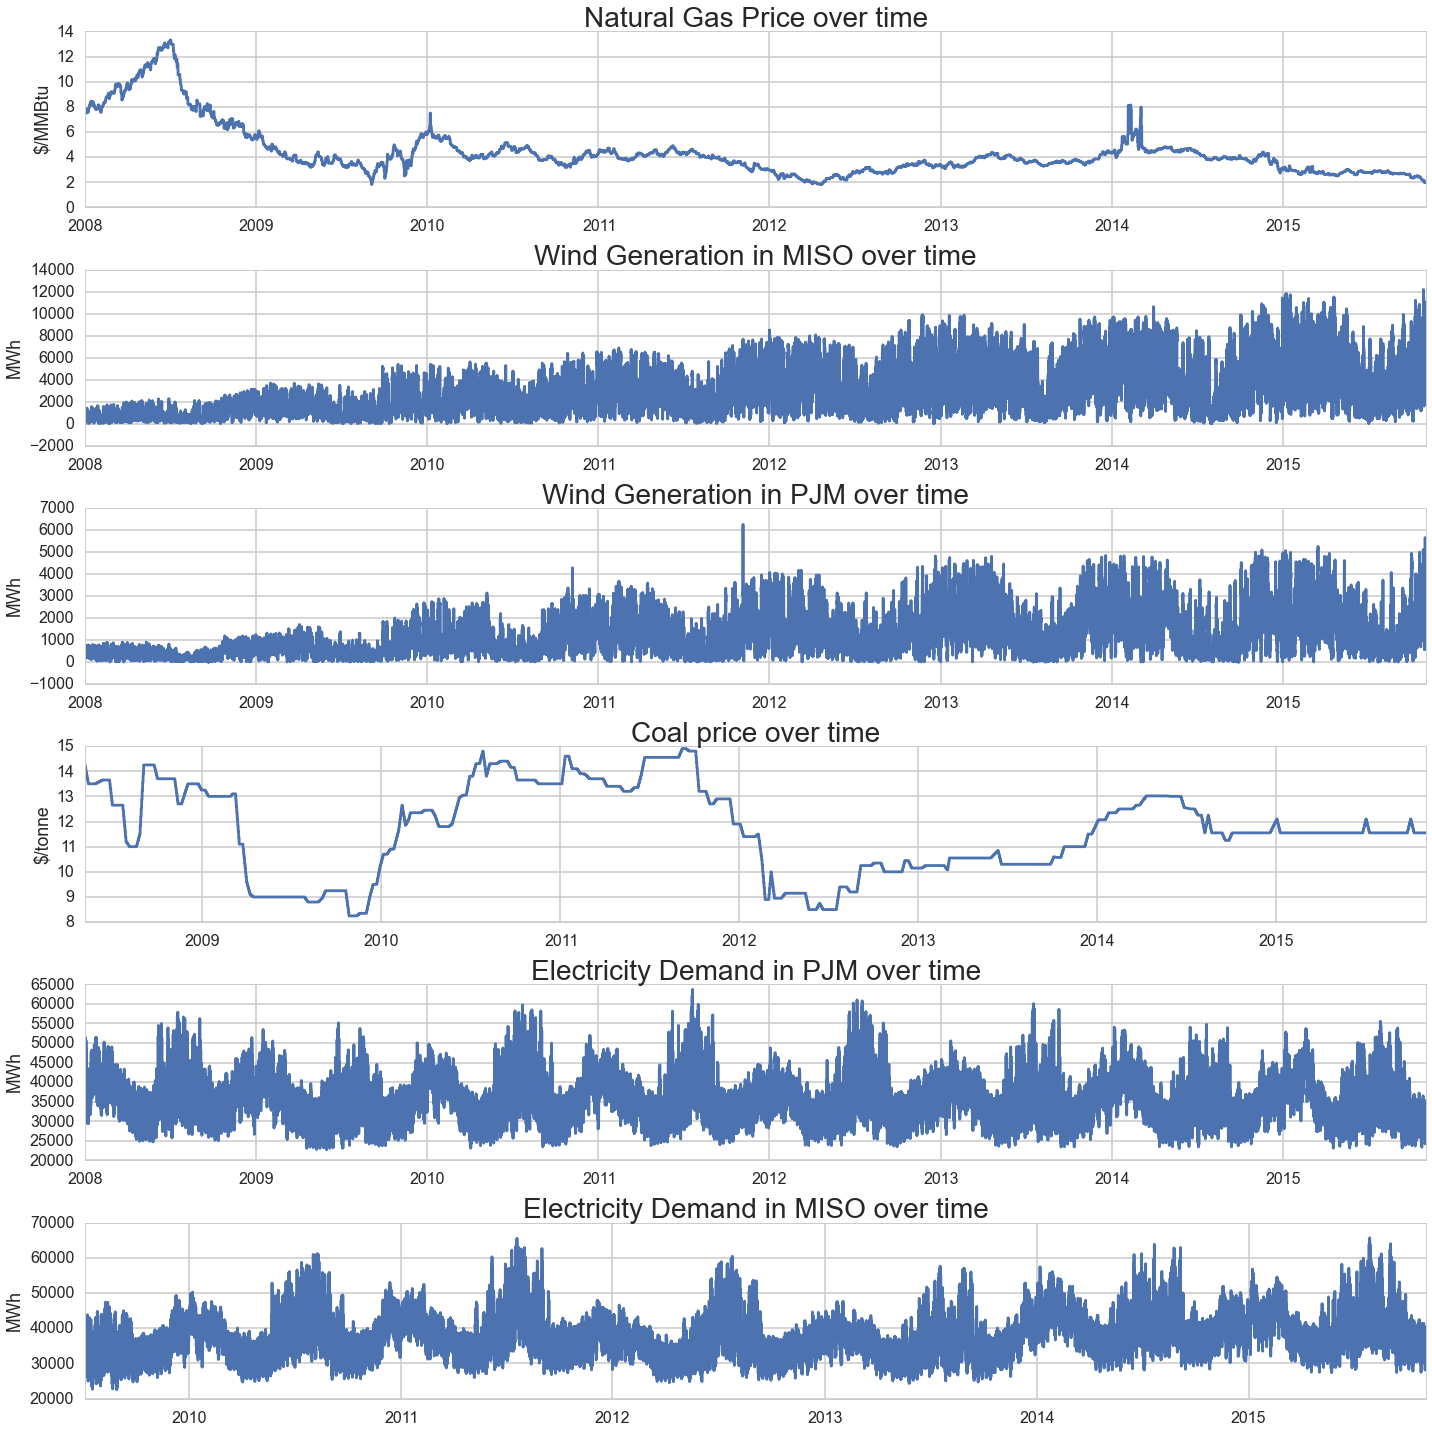

In [79]:
import matplotlib.dates as mdates
fig, (ax1,ax2,ax3,ax4, ax5, ax6) = plt.subplots(nrows=6,ncols=1,figsize=(20,20),tight_layout=True)

ax1.plot(fulldf.index.to_pydatetime(), fulldf['NatGas_Price_($/MMBtu)']) 
ax1.set_ylabel('$/MMBtu')
ax1.set_title('Natural Gas Price over time', fontsize=28)
#ax1.xaxis.set_major_locator(mdates.YearLocator(1))

ax2.plot(fulldf.index.to_pydatetime(), fulldf['Wind_MISO_(MWh)']) 
ax2.set_ylabel('MWh')
ax2.set_title('Wind Generation in MISO over time', fontsize=28)

ax3.plot(fulldf.index.to_pydatetime(), fulldf['Wind_PJM_(MWh)']) 
ax3.set_ylabel('MWh')
ax3.set_title('Wind Generation in PJM over time', fontsize=28)

ax4.plot(fulldf.index.to_pydatetime(), fulldf['Coal_Powder River Basin']) 
ax4.set_ylabel('$/tonne')
ax4.set_title('Coal price over time', fontsize=28)

ax5.plot(fulldf.index.to_pydatetime(), fulldf['Demand_PJM_(MWh)']) 
ax5.set_ylabel('MWh')
ax5.set_title('Electricity Demand in PJM over time', fontsize=28)

ax6.plot(fulldf.index.to_pydatetime(), fulldf['Load_MISO_(MWh)']) 
ax6.set_ylabel('MWh')
ax6.set_title('Electricity Demand in MISO over time', fontsize=28)


Here we see the evolution of each of our features over time. A few notable trends:
- Natural gas prices peak in 2008 and then decline and plateau at a steady, if low, price
- Wind generation in both the PJM and MISO regions grows significantly each year
- Coal prices oscillate and show no discernable pattern
- Electricity demand in both regions stays relatively steady over time

#### 3.3 Histograms of each feature

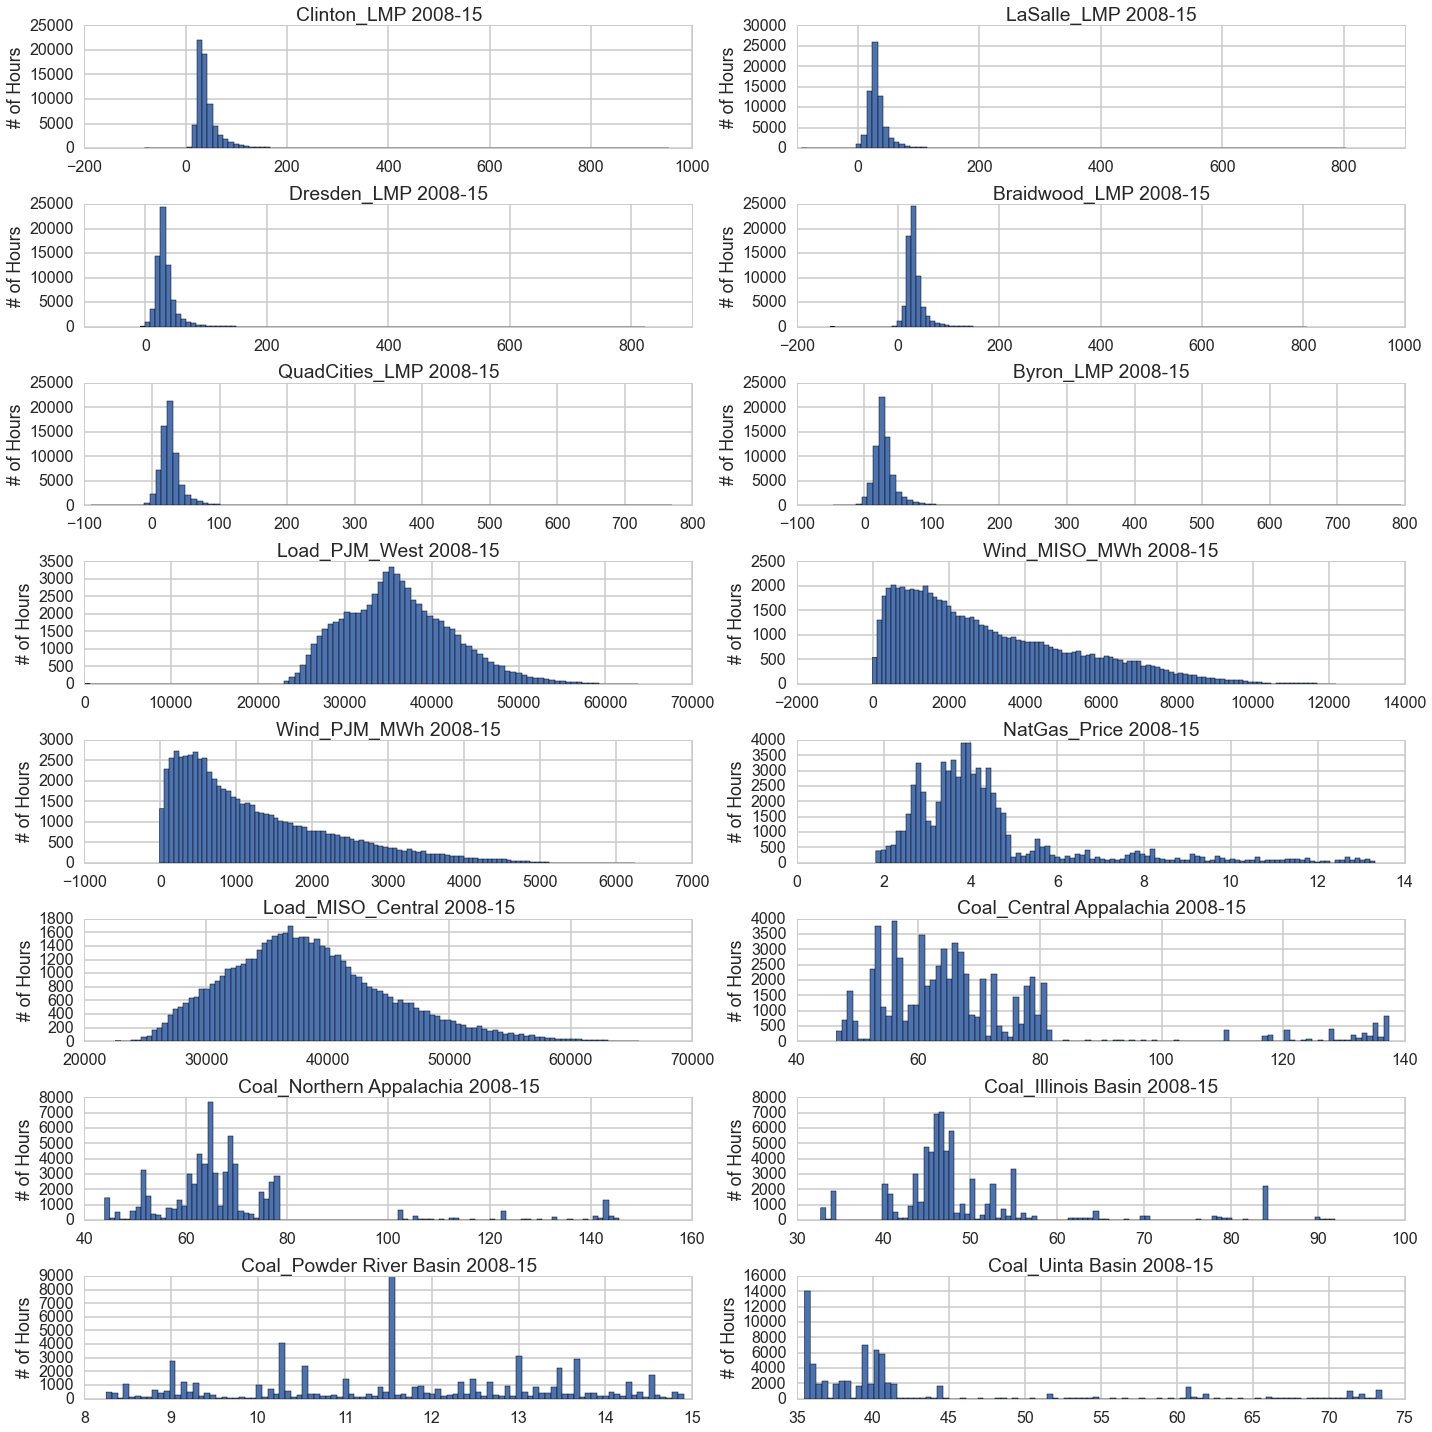

In [11]:
fig, axes = plt.subplots(nrows=8,ncols=2,figsize=(20,20),tight_layout=True)
headers = list(fulldf)
ax = axes.ravel()

for i in range(16):
    fulldf.iloc[:,i].hist(bins=100, ax=ax[i])
    ax[i].set_title(headers[i] + ' 2008-15')
    ax[i].set_ylabel("# of Hours")

Histograms of each of our data points shows that electricity prices and demand are (roughly) normally distributed, while wind and gas prices are closer to a poisson distribution. Coal prices are more random.

#### 3.4 Scatter plots comparing features against electric price (Clinton)

Here we take a closer look at the relationship between features and prices by focusing on a specific node (Clinton). In other EDA workbooks we show that this relationship holds for all the nodes. 

C:\Users\huntington\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


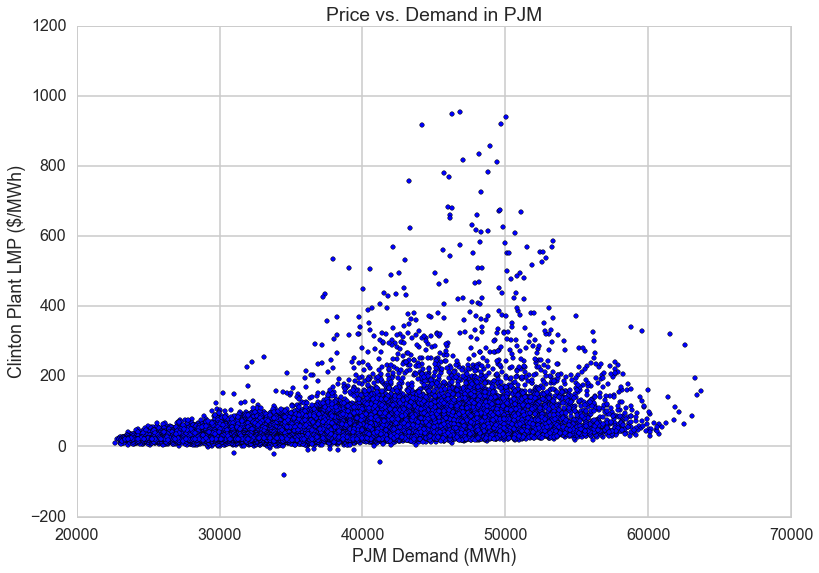

In [82]:
y = fulldf['Clinton_LMP_($/MWh)']
x = fulldf['Demand_PJM_(MWh)']
plt.scatter(x,y)
plt.xlabel('PJM Demand (MWh)')
plt.ylabel('Clinton Plant LMP ($/MWh)')
plt.title('Price vs. Demand in PJM')

While there are a lot of outliers, there is also a clear relationship between increased demand and increased prices

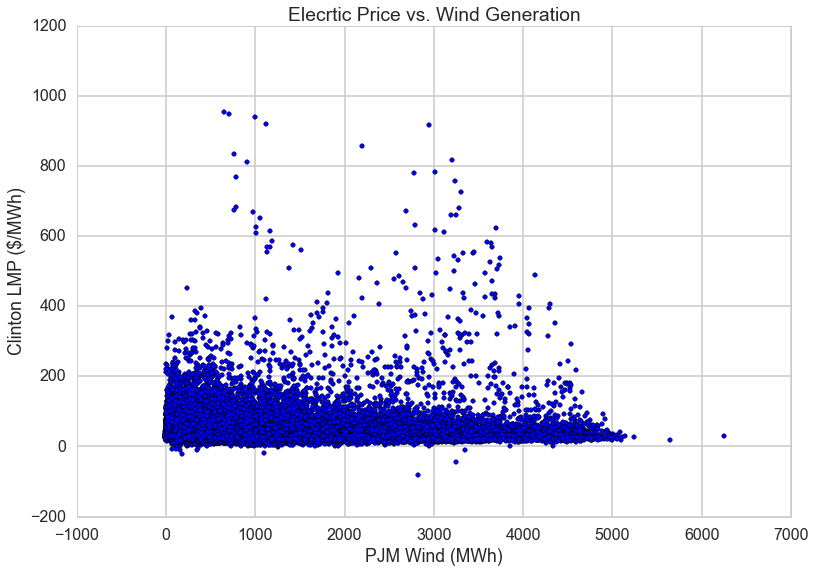

In [84]:
y = fulldf['Clinton_LMP_($/MWh)']
x = fulldf['Wind_PJM_(MWh)']
plt.scatter(x,y)
plt.xlabel('PJM Wind (MWh)')
plt.ylabel('Clinton LMP ($/MWh)')
plt.title('Elecrtic Price vs. Wind Generation')

Like the previous graph there are plenty of outliers, but there is also a clear trend: greater wind generation correllates with generally lower prices. 

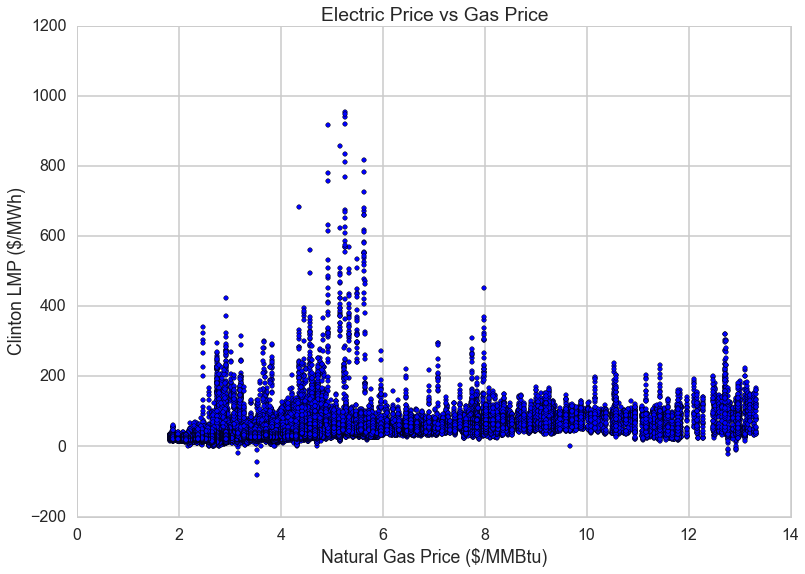

In [85]:
y = fulldf['Clinton_LMP_($/MWh)']
x = fulldf['NatGas_Price_($/MMBtu)']
plt.scatter(x,y)
plt.xlabel('Natural Gas Price ($/MMBtu)')
plt.ylabel('Clinton LMP ($/MWh)')
plt.title('Electric Price vs Gas Price')

The relationship here is not particularly strong, though prices do appear to increase with higher prices for natural gas (as we would expect).

## 4. Testing Predictive Modelling Techniques

#### 4.1 Multiple Linear Regression

In [134]:
import statsmodels.formula.api as smf

#rename columns to be able to use formula-style notation (can't handle $ character)
nfulldf=fulldf.copy()
nfulldf.columns = ['Clinton_LMP','LaSalle_LMP','Dresden_LMP','Braidwood_LMP','QuadCities_LMP','Byron_LMP','Demand_PJM','Wind_MISO','Wind_PJM','NG_Price','Demand_MISO','Coal_CA','Coal_NA','Coal_IB','Coal_PRB','Coal_UB']

print "LMP_NODE    ", "   NG    ", "   PJM Load    ","   MISO Load    ","   PJM Wind    ","   MISO Wind   ", "   All minus MISO Load", "   All"
for lmp in list(nfulldf)[0:6]:
    lm0 = smf.ols(formula = lmp + ' ~ NG_Price', data = nfulldf).fit()
    lm1 = smf.ols(formula = lmp + ' ~ Demand_PJM', data = nfulldf).fit()
    lm2 = smf.ols(formula = lmp + ' ~ Demand_MISO', data = nfulldf).fit()
    lm3 = smf.ols(formula = lmp + ' ~ Wind_PJM', data = nfulldf).fit()
    lm4 = smf.ols(formula = lmp + ' ~ Wind_MISO', data = nfulldf).fit()
    lm5 = smf.ols(formula = lmp + ' ~ NG_Price + Demand_PJM + Wind_PJM + Wind_MISO', data = nfulldf).fit()
    lm6 = smf.ols(formula = lmp + ' ~ NG_Price + Demand_PJM + Wind_PJM + Wind_MISO + Demand_MISO', data = nfulldf).fit()  
    print lmp, ':   ', lm0.rsquared, lm1.rsquared, lm2.rsquared, lm3.rsquared, lm4.rsquared, lm5.rsquared, lm6.rsquared

LMP_NODE        NG        PJM Load        MISO Load        PJM Wind        MISO Wind       All minus MISO Load    All
Clinton_LMP :    0.155870426117 0.16156253252 0.179985571045 0.00759915146454 0.00674815154949 0.286853521954 0.2526493751
LaSalle_LMP :    0.136671738294 0.185792884635 0.295095451351 0.0200163738526 0.0130028462486 0.287616384062 0.333220961629
Dresden_LMP :    0.134290774542 0.186209579935 0.295985069593 0.0191234376246 0.0117192938701 0.286366247564 0.335265122514
Braidwood_LMP :    0.13739032207 0.184892308846 0.293317711292 0.0209962588914 0.0141746537575 0.287116689298 0.330748777421
QuadCities_LMP :    0.193208730516 0.152317489171 0.258956901098 0.0364742033846 0.0355512813481 0.307011146204 0.307815231564
Byron_LMP :    0.160775706423 0.173242195796 0.283677340925 0.0253652843335 0.0189055786615 0.296641248179 0.326836456155


We see at least some correllation between price and each of the features, and the r^2 generally improves as we add features (see last two columns). However, the overall r^2 remains low

In [135]:
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Byron_LMP   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     5382.
Date:                Tue, 08 Dec 2015   Prob (F-statistic):               0.00
Time:                        02:28:47   Log-Likelihood:            -2.3269e+05
No. Observations:               55430   AIC:                         4.654e+05
Df Residuals:                   55424   BIC:                         4.654e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     -46.7968      0.527    -88.734      0.000       -47.831   -45.763
NG_Price        4.6544      0.081     57.381      0.000         4.495     4.813
Demand_PJM      0.0001   1.32e-05      9.183      0.000       9.5e-05     0.000
Wind_PJM       -0.0006   7.83e-05     -8.155      0.000        -0.001    -0.000
Wind_MISO       0.0002   3.56e-05      4.873      0.000         0.000     0.000
Demand_MISO     0.0014   1.24e-05    112.101      0.000         0.001     0.001
==============================================================================
Omnibus:                   108825.941   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        592509935.069
Skew:                          15.430   Prob(JB):                         0.00
Kurtosis:                     508.561   Cond. No.                     4.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 4.2 Ridge Regression

Here we add some additional features related to the date and time in an attempt to capture the cyclical effects of timeseries data

In [136]:
fulldf_wTime = fulldf
fulldf_wTime['Month'] = pd.to_datetime(fulldf_wTime.index).month
fulldf_wTime['day_of_week']= pd.to_datetime(fulldf_wTime.index).dayofweek
fulldf_wTime['hour_of_day']= pd.to_datetime(fulldf_wTime.index).hour
fulldf_wTime.head(2)

,Clinton_LMP_($/MWh),LaSalle_LMP_($/MWh),Dresden_LMP_($/MWh),Braidwood_LMP_($/MWh),QuadCities_LMP_($/MWh),Byron_LMP_($/MWh),Demand_PJM_(MWh),Wind_MISO_(MWh),Wind_PJM_(MWh),NatGas_Price_($/MMBtu),Load_MISO_(MWh),Coal_Central Appalachia,Coal_Northern Appalachia,Coal_Illinois Basin,Coal_Powder River Basin,Coal_Uinta Basin,Month,day_of_week,hour_of_day
2008-01-01 00:00:00,42.90,24.055,24.39,24.145,23.45,23.580,33534,1104.05,697.102,7.83,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0
2008-01-01 01:00:00,39.33,23.015,23.32,23.100,22.40,22.455,32632,1210.31,679.046,7.83,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1


In [137]:
# Hourly
d = '2009-07-06 00:00:00'
lmp1df = fulldf_wTime.ix[d:]
lst = list(fulldf_wTime.iloc[:,5:19])
lmp1df = lmp1df[lst]
inds = pd.isnull(lmp1df).any(1).nonzero()[0]
for i in inds:
    lmp1df.iloc[i] = np.mean([lmp1df.iloc[i+1][0],lmp1df.iloc[i-1][0]])
lmp1df.head(2)


,Byron_LMP_($/MWh),Demand_PJM_(MWh),Wind_MISO_(MWh),Wind_PJM_(MWh),NatGas_Price_($/MMBtu),Load_MISO_(MWh),Coal_Central Appalachia,Coal_Northern Appalachia,Coal_Illinois Basin,Coal_Powder River Basin,Coal_Uinta Basin,Month,day_of_week,hour_of_day
2009-07-06 00:00:00,17.34,25336.338,313.94,92.4,3.24,26274.67,53.333333,51.166667,44,9,44.5,7,0,0
2009-07-06 01:00:00,10.86,25424.452,288.85,82.8,3.24,25008.58,53.333333,51.166667,44,9,44.5,7,0,1


In [138]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import linear_model


# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(lmp1df.drop('Byron_LMP_($/MWh)', axis=1), lmp1df['Byron_LMP_($/MWh)'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)


# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  50.0

R2 Score:  0.344590217378
Explained Variance Score:  0.344604953374
MAE:  7.58616464358
MSE:  282.030463863
Median AE:  5.48873479252



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
3,NatGas_Price_($/MMBtu),5.382617e+00
6,Coal_Northern Appalachia,3.956994e-01
12,hour_of_day,1.250333e-01
5,Coal_Central Appalachia,9.613298e-02
4,Load_MISO_(MWh),1.407017e-03
0,Demand_PJM_(MWh),9.452272e-05
1,Wind_MISO_(MWh),7.118219e-07
2,Wind_PJM_(MWh),-1.052639e-03
11,day_of_week,-2.825725e-02
7,Coal_Illinois Basin,-2.049613e-01


Ridge regression returns almost an identical score to the OLS multiple regression which makes sense as they're doing very similar things. Now we try Ridge regression with daily data points to see if removing the noise associated with hourly data improves results

In [139]:
# d = '2009-07-06 00:00:00'
# dfulldf = fulldf_wTime.ix[d:]
# lst = list(fulldf_wTime.iloc[:,5:19])
# dfulldf = dfulldf[lst]
dfulldf = lmp1df.groupby(pd.TimeGrouper('D')).transform(np.mean).resample('D') #, how='ohlc'
print "number of hourly data points: ", len(fulldf)
print "number of daily data points: ", len(dfulldf)

number of hourly data points:  68688
number of daily data points:  2310


In [140]:
# Daily
# d = '2009-07-06'
# lmp1df = dfulldf.ix[d:]
# lmp1df = lmp1df[['Clinton_LMP','NatGas_Price', 'Wind_MISO_(MWh)','Wind_PJM_(MWh)','Demand_PJM_(MWh)','Load_MISO_Central']]
# #lmp1df = lmp1df[['lmp_601','NG_HH', 'Wind_MISO','Wind_PJM','Load_PJM_West']]
# lmp1df.head(2)

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(dfulldf.drop('Byron_LMP_($/MWh)', axis=1), dfulldf['Byron_LMP_($/MWh)'], 
                                                    test_size=0.2, random_state=0)

# Gridsearch + Fit
ridge = linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 5e1, 9e1, 1e2, 2e2, 5e2, 1e3], cv=5)
fit = ridge.fit(X_train, y_train)

# Metrics
print 'Best Params: ', fit.alpha_
print
preds = ridge.predict(X_test)
print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
print

# Regression Coefficients
lcols = X_train.columns
pd.DataFrame(zip(lcols, fit.coef_), columns=['Predictors', 'Coefficients']).sort('Coefficients', ascending=False)

Best Params:  50.0

R2 Score:  0.378502491446
Explained Variance Score:  0.380618097801
MAE:  6.1889302144
MSE:  159.503942848
Median AE:  4.07619478586



/Users/x/anaconda/envs/data/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Predictors,Coefficients
3,NatGas_Price_($/MMBtu),5.351161
6,Coal_Northern Appalachia,0.423420
0,Demand_PJM_(MWh),0.001159
1,Wind_MISO_(MWh),0.000177
4,Load_MISO_(MWh),-0.000076
2,Wind_PJM_(MWh),-0.001587
12,hour_of_day,-0.134753
8,Coal_Powder River Basin,-0.172654
5,Coal_Central Appalachia,-0.219277
7,Coal_Illinois Basin,-0.251405


As we suspected, moving to daily averages improves the r^2 of the model, though only slightly

#### 4.3 Random Forest Regressor

Regression forests are an ensemble of different regression trees and are used for non-linear multiple regression. Our EDA has shown numerous non-linearlity in the relationships between features, making random forest regressor a good fit for our model.

In [277]:
# Narrow down DataFrame to desired starting date
dt_start = '2009-07-06'
df_main = fulldf.ix[dt_start:]

# Add in calendar features
df_main.loc[:, 'month'] = pd.to_datetime(df_main.index).month
df_main.loc[:, 'day_of_week']= pd.to_datetime(df_main.index).dayofweek
df_main.loc[:, 'hour_of_day']= pd.to_datetime(df_main.index).hour

# Construct DataFrame of common explanatory variables
df_explanatory = df_main.drop(['Clinton_LMP_($/MWh)', 'LaSalle_LMP_($/MWh)', 'Dresden_LMP_($/MWh)',
                               'Braidwood_LMP_($/MWh)', 'QuadCities_LMP_($/MWh)', 'Byron_LMP_($/MWh)']
                              , axis=1)

# Construct DataFrame for each node
df_clinton = pd.concat(   [df_explanatory, df_main['Clinton_LMP_($/MWh)']], axis=1)
df_lasalle = pd.concat(   [df_explanatory, df_main['LaSalle_LMP_($/MWh)']], axis=1)
df_dresden = pd.concat(   [df_explanatory, df_main['Dresden_LMP_($/MWh)']], axis=1)
df_braidwood = pd.concat( [df_explanatory, df_main['Braidwood_LMP_($/MWh)']], axis=1)
df_quadcities = pd.concat([df_explanatory, df_main['QuadCities_LMP_($/MWh)']], axis=1)
df_byron = pd.concat(     [df_explanatory, df_main['Byron_LMP_($/MWh)']], axis=1)

# Interpolate to fillna
df_clinton = df_clinton.interpolate()
df_lasalle = df_lasalle.interpolate()
df_dresden = df_dresden.interpolate()
df_braidwood = df_braidwood.interpolate()
df_quadcities = df_quadcities.interpolate()
df_byron = df_byron.interpolate()

# df_clinton.head(2)

In [124]:
def randomForestRegresssion(df_X, df_Y):
    
    from sklearn.cross_validation import train_test_split
    from sklearn import grid_search
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import metrics
    from scipy import stats

    # Split into training/testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0)

    # Gridsearch
    params = {
            'max_features': ['log2'],
            'n_estimators': [75],
            'max_depth': [None],
            'min_samples_split': [2]
    }
    clf = grid_search.GridSearchCV(RandomForestRegressor(n_jobs=3), params, cv=5, n_jobs=1)
    fit = clf.fit(X_train, y_train)


    # Best Estimator
    rf = fit.best_estimator_


    # Metrics
    print 'Best Params: ', fit.best_params_
    print 'Best Score: ', fit.best_score_
    print
    preds = rf.predict(X_test)
    print 'R2 Score: ', metrics.r2_score(y_test.values, preds)
    print 'Explained Variance Score: ', metrics.explained_variance_score(y_test.values, preds)
    print 'MAE: ', metrics.mean_absolute_error(y_test.values, preds)
    print 'MSE: ', metrics.mean_squared_error(y_test.values, preds)
    print 'Median AE: ', metrics.median_absolute_error(y_test.values, preds)
    print

    # Feature Importances
    lcols = X_train.columns
    display( pd.DataFrame(zip(lcols, rf.feature_importances_), columns=['Predictors', 'Feature Importances']).sort_values('Feature Importances', ascending=False) )
    
    return rf

#### 4.3.1 Random Forest Regressor on Clinton

In [303]:
rf_clinton = randomForestRegresssion(df_clinton.drop('Clinton_LMP_($/MWh)', axis=1), df_clinton['Clinton_LMP_($/MWh)'])

Best Params:  {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.902251167562

R2 Score:  0.927667276753
Explained Variance Score:  0.927695428692
MAE:  3.53839746272
MSE:  76.7506898391
Median AE:  1.703



,Predictors,Feature Importances
4,Load_MISO_(MWh),0.208526
3,NatGas_Price_($/MMBtu),0.135994
0,Demand_PJM_(MWh),0.109308
8,Coal_Powder River Basin,0.071102
13,month,0.057831
5,Coal_Central Appalachia,0.055094
12,hour_of_day,0.054663
2,Wind_PJM_(MWh),0.054442
10,Month,0.054360
7,Coal_Illinois Basin,0.047388


#### 4.3.2 Random Forest Regressor on LaSalle

In [127]:
rf_lasalle = randomForestRegresssion(df_lasalle.drop('LaSalle_LMP_($/MWh)', axis=1), df_lasalle['LaSalle_LMP_($/MWh)'])

Best Params:  {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.857035556735

R2 Score:  0.920496419897
Explained Variance Score:  0.920526089978
MAE:  2.47165132275
MSE:  32.0325337014
Median AE:  1.39326666667



,Predictors,Feature Importances
4,Load_MISO_(MWh),0.304637
12,hour_of_day,0.130431
3,NatGas_Price_($/MMBtu),0.119292
0,Demand_PJM_(MWh),0.111651
2,Wind_PJM_(MWh),0.065522
1,Wind_MISO_(MWh),0.044982
10,month,0.040712
5,Coal_Central Appalachia,0.034880
8,Coal_Powder River Basin,0.033557
9,Coal_Uinta Basin,0.031047


#### 4.3.3 Random Forest Regressor on Dresden

In [128]:
rf_dresden = randomForestRegresssion(df_dresden.drop('Dresden_LMP_($/MWh)', axis=1), df_dresden['Dresden_LMP_($/MWh)'])

Best Params:  {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.86627245954

R2 Score:  0.930943741402
Explained Variance Score:  0.930973781356
MAE:  2.40653325517
MSE:  28.5652596666
Median AE:  1.3559



,Predictors,Feature Importances
4,Load_MISO_(MWh),0.294054
12,hour_of_day,0.124516
3,NatGas_Price_($/MMBtu),0.123610
0,Demand_PJM_(MWh),0.109168
2,Wind_PJM_(MWh),0.069603
1,Wind_MISO_(MWh),0.045091
5,Coal_Central Appalachia,0.041297
10,month,0.040695
8,Coal_Powder River Basin,0.036963
11,day_of_week,0.033390


#### 4.3.4 Random Forest Regressor on Braidwood

In [129]:
rf_braidwood = randomForestRegresssion(df_braidwood.drop('Braidwood_LMP_($/MWh)', axis=1), df_braidwood['Braidwood_LMP_($/MWh)'])

Best Params:  {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.858831644082

R2 Score:  0.927661149972
Explained Variance Score:  0.9276796278
MAE:  2.49030749759
MSE:  29.7510813494
Median AE:  1.40393333333



,Predictors,Feature Importances
4,Load_MISO_(MWh),0.286305
3,NatGas_Price_($/MMBtu),0.130506
12,hour_of_day,0.128738
0,Demand_PJM_(MWh),0.112890
2,Wind_PJM_(MWh),0.062455
1,Wind_MISO_(MWh),0.045647
10,month,0.038939
8,Coal_Powder River Basin,0.036293
9,Coal_Uinta Basin,0.035494
6,Coal_Northern Appalachia,0.032921


#### 4.3.5 Random Forest Regressor on Quadcities

In [130]:
rf_quadcities = randomForestRegresssion(df_quadcities.drop('QuadCities_LMP_($/MWh)', axis=1), df_quadcities['QuadCities_LMP_($/MWh)'])

Best Params:  {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.838753706349

R2 Score:  0.908301281057
Explained Variance Score:  0.908390338582
MAE:  2.91817019601
MSE:  35.1368981506
Median AE:  1.7512



,Predictors,Feature Importances
4,Load_MISO_(MWh),0.273237
12,hour_of_day,0.141439
3,NatGas_Price_($/MMBtu),0.122306
0,Demand_PJM_(MWh),0.094202
2,Wind_PJM_(MWh),0.069310
1,Wind_MISO_(MWh),0.050133
5,Coal_Central Appalachia,0.042084
11,day_of_week,0.037506
6,Coal_Northern Appalachia,0.036846
10,month,0.036693


#### 4.3.6 Random Forest Regressor on Byron

In [131]:
rf_byron = randomForestRegresssion(df_byron.drop('Byron_LMP_($/MWh)', axis=1), df_byron['Byron_LMP_($/MWh)'])

Best Params:  {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 75, 'max_depth': None}
Best Score:  0.861613220531

R2 Score:  0.92653535568
Explained Variance Score:  0.926579632576
MAE:  2.75794809404
MSE:  31.6126921879
Median AE:  1.62486666667



,Predictors,Feature Importances
4,Load_MISO_(MWh),0.284896
3,NatGas_Price_($/MMBtu),0.126615
12,hour_of_day,0.124470
0,Demand_PJM_(MWh),0.098392
2,Wind_PJM_(MWh),0.072472
10,month,0.042433
9,Coal_Uinta Basin,0.041948
1,Wind_MISO_(MWh),0.041908
5,Coal_Central Appalachia,0.041862
8,Coal_Powder River Basin,0.037236


With a 0.91-0.93 $r^2$, Random Forest regression shows dramatic improvment over Ridge and Mulitple linear regression. 

The most significant factor in determining LMP is the electricity demand in MISO, followed by the price of natural gas. The amount of wind generation does influence the LMP but to a much lesser extend than the price of natural gas.

## 5. Final Analysis: Forward Forecasting

#### 5.1 Function to increase a Feature of the model by a specific amount by a certain year

In [379]:
def increaseModelFeature(df, increaseFeature, increasePct, increaseEndYear):

# #     Test parameters
#     increaseFeature = 'Wind_PJM_(MWh)'
#     increasePct = 100
#     increaseEndYear = 2030

    increaseEndDate = str(increaseEndYear) + '-12-31'
    df = df.copy()

    # Set final row values
    df.ix[increaseEndDate] = df.ix[-1]
    df.ix[increaseEndDate][increaseFeature] = df.ix[increaseEndDate][increaseFeature] * (100 + increasePct)/100.0

    # Create rows between final row of extrapolated DataFrame and final row of original DataFrame
    # and resample to Daily frequency
    df.index = pd.to_datetime(df.index)
    df = df.resample('D')

    # Interpolate values
    df = df.interpolate()
    
    return df

#### 5.2 Double Wind Generation

Change in LMP:  1.04 %


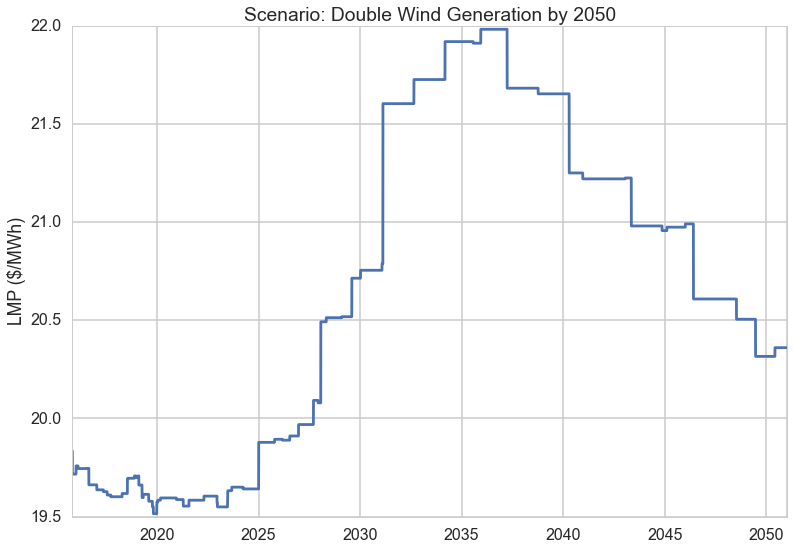

In [438]:
# Scenario parameters
changedFeature = 'Wind_PJM_(MWh)'
changePct = 100
changeEndYear = 2050

df = df_clinton
lmpColName = 'Clinton_LMP_($/MWh)'
rf = rf_clinton



# Construct extrapolated DataFrame
df_extrapolated = increaseModelFeature(df, changedFeature, changePct, changeEndYear)

# Perform prediction
df_X = df_extrapolated.drop(lmpColName, axis=1)
df_X = df_X.ix[df.index.max().date():]
pred_lmp = rf.predict(df_X)

# Visualize LMP predictions
df_lmp = pd.DataFrame(pred_lmp, index=df_X.index)
df_lmp.plot(legend=False)
plt.ylabel('LMP ($/MWh)')
plt.title('Scenario: Double Wind Generation by 2050')

# Calculate change in LMP
lmpInitial = df.ix[-1][lmpColName]
lmpFinal = df_lmp.ix[-1]
lmpChange = (lmpFinal - lmpInitial) / lmpInitial * 100
print 'Change in LMP: ', round(lmpChange.values[0], 2), '%'

#### 5.3 Double Natural Gas Prices

Change in LMP:  25.4 %


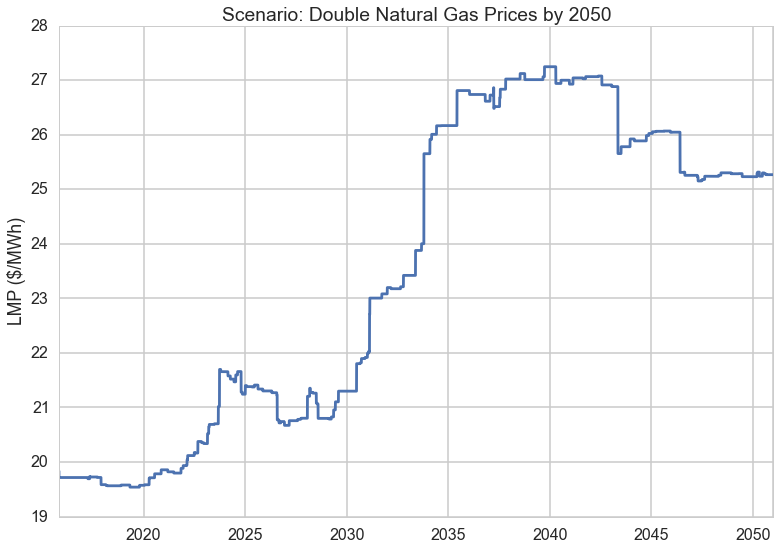

In [428]:
# Scenario parameters
changedFeature = 'NatGas_Price_($/MMBtu)'
changePct = 100
changeEndYear = 2050

df = df_clinton
lmpColName = 'Clinton_LMP_($/MWh)'
rf = rf_clinton



# Construct extrapolated DataFrame
df_extrapolated = increaseModelFeature(df, changedFeature, changePct, changeEndYear)

# Perform prediction
df_X = df_extrapolated.drop(lmpColName, axis=1)
df_X = df_X.ix[df.index.max().date():]
pred_lmp = rf.predict(df_X)

# Visualize LMP predictions
df_lmp = pd.DataFrame(pred_lmp, index=df_X.index)
df_lmp.plot(legend=False)
plt.ylabel('LMP ($/MWh)')
plt.title('Scenario: Double Natural Gas Prices by 2050')

# Calculate change in LMP
lmpInitial = df.ix[-1][lmpColName]
lmpFinal = df_lmp.ix[-1]
lmpChange = (lmpFinal - lmpInitial) / lmpInitial * 100
print 'Change in LMP: ', round(lmpChange.values[0], 2), '%'

#### 5.4 Double Electricity Demands in MISO

Change in LMP:  76.82 %


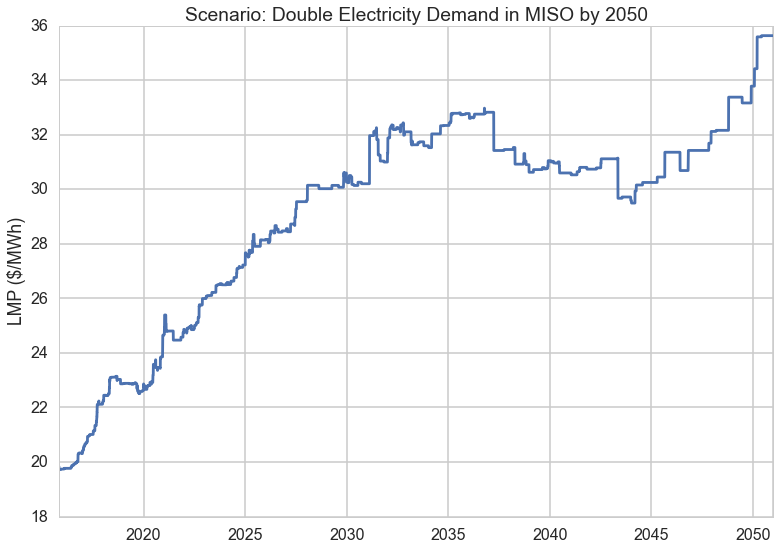

In [412]:
# Scenario parameters
changedFeature = 'Load_MISO_(MWh)'
changePct = 100
changeEndYear = 2050

df = df_clinton
lmpColName = 'Clinton_LMP_($/MWh)'
rf = rf_clinton



# Construct extrapolated DataFrame
df_extrapolated = increaseModelFeature(df, changedFeature, changePct, changeEndYear)

# Perform prediction
df_X = df_extrapolated.drop(lmpColName, axis=1)
df_X = df_X.ix[df.index.max().date():]
pred_lmp = rf.predict(df_X)

# Visualize LMP predictions
df_lmp = pd.DataFrame(pred_lmp, index=df_X.index)
df_lmp.plot(legend=False)
plt.ylabel('LMP ($/MWh)')
plt.title('Scenario: Double Electricity Demand in MISO by 2050')

# Calculate change in LMP
lmpInitial = df.ix[-1][lmpColName]
lmpFinal = df_lmp.ix[-1]
lmpChange = (lmpFinal - lmpInitial) / lmpInitial * 100
print 'Change in LMP: ', round(lmpChange.values[0], 2), '%'

#### 5.5 Free Coal

Change in LMP:  4.98 %


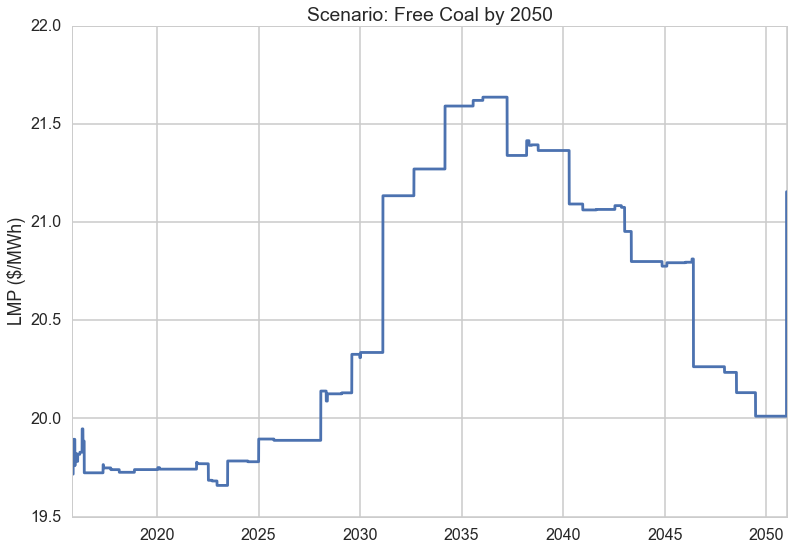

In [446]:
# Scenario parameters
changedFeature = 'Coal_Uinta Basin'
changePct = -100
changeEndYear = 2050

df = df_clinton
lmpColName = 'Clinton_LMP_($/MWh)'
rf = rf_clinton



# Construct extrapolated DataFrame
df_extrapolated = increaseModelFeature(df, 'Coal_Central Appalachia', changePct, changeEndYear)
df_extrapolated = increaseModelFeature(df_extrapolated, 'Coal_Northern Appalachia', changePct, changeEndYear)
df_extrapolated = increaseModelFeature(df_extrapolated, 'Coal_Illinois Basin', changePct, changeEndYear)
df_extrapolated = increaseModelFeature(df_extrapolated, 'Coal_Powder River Basin', changePct, changeEndYear)
df_extrapolated = increaseModelFeature(df_extrapolated, 'Coal_Uinta Basin', changePct, changeEndYear)

# Perform prediction
df_X = df_extrapolated.drop(lmpColName, axis=1)
df_X = df_X.ix[df.index.max().date():]
pred_lmp = rf.predict(df_X)

# Visualize LMP predictions
df_lmp = pd.DataFrame(pred_lmp, index=df_X.index)
df_lmp.plot(legend=False)
plt.ylabel('LMP ($/MWh)')
plt.title('Scenario: Free Coal by 2050')

# Calculate change in LMP
lmpInitial = df.ix[-1][lmpColName]
lmpFinal = df_lmp.ix[-1]
lmpChange = (lmpFinal - lmpInitial) / lmpInitial * 100
print 'Change in LMP: ', round(lmpChange.values[0], 2), '%'

In [19]:
# build dataframe for future scenarios (e.g., double wind generation, higher gas price, deep decarbonization scenario)
#       Maybe just for a years worth of data (e.g., double wind in 2020, or deep decarbonization in 2050)
# run random forest predictors using the synthetic dataframes described above (start with just a single LMP, then if its quick run it for multiple)
# output should be a year's worth of prices
# compare those to average prices over past year at a given node
# Conclusions = how much higher/lower are prices relative to current ones? (simple calcualtion)

## 6. Revisiting Initial Questions

#### 1. What factors drive electricity prices?
We answered this question through research, rather than data analysis, and used it to inform feature selection. A detailed response is given in section 2. Data and Processing

The main featuers we chose for our model were:
- electricity demand
- natural gas prices
- coal prices
- wind generation

##### 2. What trends have resulted in depressed electricity prices?
(will fill in with analysis from EDA - especially longitudinal graphs)

##### 3. How accurately can we forecast future electricity prices?
(random forest is best predictor with 93% of variance explained at hourly intervals)

##### 4. What is the impact of increased wind generation on future electricity prices?
TBD... (follows from part 6)

##### 5. What is the impact of increased natural gas prices on future electricity prices?
TBD... (follows from part 6)

## 7. Limitations and Future Improvements

1. Coal prices are 'mine mouth' rather than the delivered price seen by electric generators. While the bulk commodity price certainly correllates with the delivered price, it has a lower correllation with electricity prices and therefore reduces the predictive accuracy of the model.
2. We leverage classification rather than true time-series based prediction techniques, which may not be suitable for long term forecasting. 
3. (fill in any others you guys can think of)